# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

**Что оценивается в первую очередь:**
- Выбранная архитектура для решения задачи
- Выбранные предобученные веса 
- Полученные метрики

**Затем:**
- Глубина разведочного анализа
- Какая схема теггирования используется (**BIO, IO** или другие)
- Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)

**С меньшим приоритетом:** 
- Скорость предобработки и постобработки данных 
- Стиль кода

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2022-01-17 18:31:14--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.04s   

2022-01-17 18:31:15 (17.6 MB/s) - ‘eng.testa’ saved [827012/827012]

--2022-01-17 18:31:15--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plain]
S

In [4]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 66.2 MB/s 
     |████████████████████████████████| 3.3 MB 54.5 MB/s 
     |████████████████████████████████| 895 kB 45.1 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
from torch.utils.data import Dataset, DataLoader
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from transformers import BertTokenizerFast, BertTokenizer, AutoTokenizer, AdamW, BertModel
import torch
from transformers import BertForTokenClassification
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import accuracy_score

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', add_prefix_space=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [7]:
with open('eng.train', 'r') as f:
    lines = f.readlines()

In [8]:
lines[:10]

['-DOCSTART- -X- O O\n',
 '\n',
 'EU NNP I-NP I-ORG\n',
 'rejects VBZ I-VP O\n',
 'German JJ I-NP I-MISC\n',
 'call NN I-NP O\n',
 'to TO I-VP O\n',
 'boycott VB I-VP O\n',
 'British JJ I-NP I-MISC\n',
 'lamb NN I-NP O\n']

In [9]:
def read_data(file):
    lines = open(file, "r").readlines()
    data = {"sentences": [], "labels_per_sent": []}
    sentence, labels = [], []
    for line in tqdm(lines):
        line = line.strip()
        if not line:
            if sentence and labels:
                assert len(sentence) == len(labels)
                data["sentences"].append(sentence)
                data["labels_per_sent"].append(labels)
                sentence, labels = [], []
            continue
        if line.startswith("-DOCSTART-"):
            continue
        else:
            values = line.split(" ")
            try:
                token, _, _, label = values
                sentence.append(token)
                if label != 'O':
                    labels.append(label)
                else:
                    labels.append(label)

            except Exception as e:
                print(f"Error has occur: {e}")
                continue
    return data


train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 989633.10it/s]


In [10]:
df_train = pd.DataFrame([[' '.join(x),','.join(y)] for x,y in zip(train['sentences'],train['labels_per_sent'])], columns=['Sentence','Labels'])
df_valid = pd.DataFrame([[' '.join(x),','.join(y)] for x,y in zip(valid['sentences'],valid['labels_per_sent'])], columns=['Sentence','Labels'])

In [11]:
le = LabelEncoder()
all_tags=[]
for i in tqdm(range(len(df_train))):
    all_tags.extend(df_train['Labels'].values[i].split(','))
    
unique_tags = list(set(all_tags))
le.fit_transform(unique_tags)
labels_to_ids = dict(zip(le.transform(le.classes_), le.classes_))
ids_to_labels = {value:key for key, value in labels_to_ids .items()}

100%|██████████| 14041/14041 [00:00<00:00, 201076.95it/s]


In [12]:
def get_label_distribution(labels: List[List[str]]):
    labels = [label for labels_per_sent in labels for label in labels_per_sent]
    return Counter(labels)

In [13]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

Train distribution


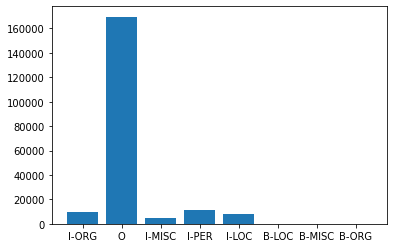

Valid distribution


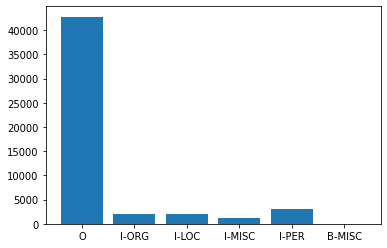

In [14]:
def visualize_distr(data: Counter):
    labels = list(data.keys())
    plt.bar(x=labels, height=list(data.values()))
    plt.show()
    

print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

Построим гистограммы на одном графике, чтобы было понятнее распределение токенов на трейне/валидации

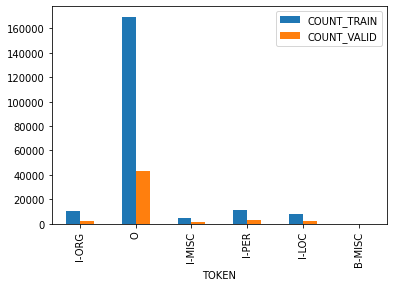

In [15]:
train_distribution_df = pd.DataFrame([[x,y] for x,y in train_distribution.items()], columns=['TOKEN','COUNT_TRAIN'])
valid_distribution_df = pd.DataFrame([[x,y] for x,y in valid_distribution.items()], columns=['TOKEN','COUNT_VALID'])
distribution_df = pd.merge(train_distribution_df, valid_distribution_df, on='TOKEN')
distribution_df.set_index('TOKEN').plot.bar()

In [16]:
Counter([x for y in [x for x in list(df_train.Labels.apply(lambda x: x.split(',')).values)] for x in y])

Counter({'B-LOC': 11,
         'B-MISC': 37,
         'B-ORG': 24,
         'I-LOC': 8286,
         'I-MISC': 4556,
         'I-ORG': 10001,
         'I-PER': 11128,
         'O': 169578})

In [17]:
Counter([x for y in [x for x in list(df_valid.Labels.apply(lambda x: x.split(',')).values)] for x in y])

Counter({'B-MISC': 4,
         'I-LOC': 2094,
         'I-MISC': 1264,
         'I-ORG': 2092,
         'I-PER': 3149,
         'O': 42759})

Можно заметить, что b-token'ов довольно мало, поэтому метрики будем считать по токенам, а не спанам сущностей, но мы их оставим для обучения, чтобы посмотреть, как модель сможет предиктить 4 b-misc токена.

In [18]:
df_train.Sentence.apply(lambda x: len(x)).mean(), df_train.Sentence.apply(lambda x: len(x)).max()

(76.89067730218646, 512)

In [19]:
df_valid.Sentence.apply(lambda x: len(x)).mean(), df_valid.Sentence.apply(lambda x: len(x)).max()

(83.78738461538461, 438)

In [20]:
LABEL_ALL_SUBTOKENS = True
class NERDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len, get_wids = False):
        self.data = dataframe
        self.len = len(dataframe)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.get_wids = get_wids
        
    def __getitem__(self,index):
        text = self.data['Sentence'].values[index]        
        word_labels = self.data['Labels'].values[index].split(',')

        # TOKENIZE TEXT
        encoding = self.tokenizer(text.split(),
                             is_split_into_words=True,
                             #return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
#                              return_tensors='pt',
                             max_length=self.max_len,
                             )
        word_ids = encoding.word_ids()  

        # CREATE TARGETS
        if not self.get_wids:
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:                            
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:              
                    label_ids.append( le.transform([word_labels[word_idx]]))
                else:
                    if LABEL_ALL_SUBTOKENS:
                        label_ids.append( le.transform([word_labels[word_idx]]) )
                    else:
                        label_ids.append(-100)
                previous_word_idx = word_idx
            encoding['labels'] = label_ids

        # CONVERT TO TORCH TENSORS
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        if self.get_wids: 
            word_ids2 = [w if w is not None else -1 for w in word_ids]
            item['wids'] = torch.as_tensor(word_ids2)

        return item
    
    def __len__(self):
        return self.len

train_dataset = NERDataset(df_train, tokenizer, 128)
valid_dataset = NERDataset(df_valid, tokenizer, 128)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [22]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

В качестве модели берем предобученный берт, так как он дает очень хорошее качество.

In [23]:
len(labels_to_ids)

8

In [25]:
# class NERModel(nn.Module):

#     def __init__(self, labels_to_ids):
#         super(NERModel,self).__init__()
#         self.labels_to_ids = labels_to_ids
#         self.bert = BertModel.from_pretrained('bert-base-uncased', num_labels=len(self.labels_to_ids))
#         prob, D_in, H,D_out = 0.3 ,768 ,30, len(self.labels_to_ids)
    
#         self.classifier = nn.Sequential(
#             nn.Dropout(prob),
#             nn.Linear(D_in, H),
#             nn.ReLU(),
#             nn.Linear(H, D_out))
        
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, input_ids, token_type_ids, attention_mask, labels=None):
#         outputs = self.bert(input_ids=input_ids, token_type_ids = token_type_ids, attention_mask = attention_mask, labels = labels)
#         last_hidden_state_cls = outputs[0]
#         logit = self.classifier(last_hidden_state_cls)
#         return self.sigmoid(logit)

In [26]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [27]:
model = model.to(device)

In [28]:
def transform_logits(predictions: List[torch.tensor]):
    predics = predictions.detach().cpu().numpy()
    predict_labels_per_sentence = [ids_to_labels[x] for x in predics]
    return predict_labels_per_sentence

def transform_target(target_labels: List[torch.tensor]):
    real_labels = [list(x) for y in target_labels for x in y.detach().cpu().numpy()]
    real_labels = [[x if x != -100 else 2 for x in y] for y in real_labels]
    gold_labels_per_sentence = [[ids_to_labels[x] for x in y] for y in real_labels]
    return gold_labels_per_sentence

def transform_logits_and_targets(labels: List[torch.tensor], logits: List[torch.tensor], num_labels):
    flattened_targets = labels.view(-1)
    active_logits = logits.view(-1, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1)

    active_accuracy = labels.view(-1) != -100

    predict_labels_per_sentence = torch.masked_select(flattened_targets, active_accuracy)
    gold_labels_per_sentence = torch.masked_select(flattened_predictions, active_accuracy)
    return gold_labels_per_sentence, predict_labels_per_sentence

In [29]:
def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]):
    gold_labels = gold_labels_per_sentence.detach().cpu().numpy()
    predict_labels = predict_labels_per_sentence.detach().cpu().numpy()
    print(classification_report(gold_labels, predict_labels))

In [30]:
def flat_accuracy(preds: torch.tensor, labels:torch.tensor):
    pred_flat = preds.flatten().detach().cpu().numpy()
    labels_flat = labels.flatten().detach().cpu().numpy()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
optimizer = AdamW(model.parameters(), lr=5e-6)

In [32]:
def train(model, optimizer, epochs, train_dataloader, evaluation=True, valid_dataloader = None):
    '''
    Function to train model
    Function returns trained model and dictionary of losses
    Input parametres:
        model - torch model to be trained
        optimizer - optimizer that is used in training
        epochs - number of training epochs
        train_dataloader - data that is used in training
        evaluation (default = True) - booalen, True if evaluation on valid_dataloader is required
        valid_dataloader (default = None) - dataloader that is used for evaluation
    '''
    losses = {"train_losses": [], "valid_losses": []}
    
    for epoch in range(epochs):

        print(f"Start epoch #{epoch + 1}")
        losses_list = []
        model.train()
        for i,train_batch in enumerate(train_dataloader):
            model.zero_grad()
            b_input_ids_pos,b_token_type_ids, b_attn_mask_pos, b_labels = tuple(t.to(device) for t in train_batch.values())
            output = model(b_input_ids_pos,token_type_ids = None, attention_mask = b_attn_mask_pos, labels= b_labels)
            loss, logits = output.loss, output.logits
            losses_list.append(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            loss.backward()


            optimizer.step()
            print(f'batch {i}/{len(train_dataloader)} loss: {loss}',end='\r')
            predict_labels, gold_labels = [], []
        losses['train_losses'].append(torch.mean(torch.tensor(losses_list).float()))

        if evaluation:
            valid_loss = evaluate(model, valid_dataloader)
            losses['valid_losses'].append(valid_loss)
    return model, losses
def evaluate(model, valid_dataloader):
    '''
    Function to evaluate model:
    Function prints accuracy and classification report for evaluation data and return mean loss.
    Input parameters:
        model - pytorch model to be evaluated
        valid_dataloader - dataloader that is used for evaluation
    '''
    model.eval()
    losses = []
    gold_labels = []
    logits_list = []
    for valid_batch in valid_dataloader:

        b_input_ids_pos,b_token_type_ids, b_attn_mask_pos, b_labels = tuple(t.to(device) for t in valid_batch.values())
        with torch.no_grad():
            output = model(b_input_ids_pos,token_type_ids = None, attention_mask = b_attn_mask_pos, labels=b_labels)
        loss, logits = output.loss, output.logits
        losses.append(loss)
        logits = output.logits
        label_ids = b_labels
        gold_labels.append(b_labels)
        logits_list.append(logits)

    logits_list = torch.cat(logits_list,0) 
    gold_labels = torch.cat(gold_labels, 0)
    gold_labels_per_sentence, predict_labels_per_sentence  = transform_logits_and_targets(gold_labels, logits_list, model.num_labels)
    
    print('_'*25)
    print(f'Accuracy {flat_accuracy(gold_labels_per_sentence, predict_labels_per_sentence)}')
    print(f'classification report:')
    print(count_metrics(gold_labels_per_sentence, predict_labels_per_sentence))
    
    return torch.mean(torch.tensor(losses).float())


In [33]:
model, losses = train(model, optimizer, 5, train_dataloader, evaluation=True, valid_dataloader=valid_dataloader)

Start epoch #1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


_________________________
Accuracy 0.969596312778131
classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.95      0.82      0.88      3382
           4       0.53      0.76      0.63      1126
           5       0.86      0.84      0.85      3039
           6       0.99      0.98      0.98      5883
           7       0.99      0.99      0.99     49490

    accuracy                           0.97     62920
   macro avg       0.72      0.73      0.72     62920
weighted avg       0.97      0.97      0.97     62920

None
Start epoch #2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________
Accuracy 0.9805626191989828
classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.96      0.93      0.94      3000
           4       0.78      0.79      0.79      1602
           5       0.90      0.91      0.91      2924
           6       0.99      0.98      0.99      5863
           7       0.99      0.99      0.99     49531

    accuracy                           0.98     62920
   macro avg       0.77      0.77      0.77     62920
weighted avg       0.98      0.98      0.98     62920

None
Start epoch #3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________
Accuracy 0.9836935791481246
classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.96      0.95      0.95      2940
           4       0.81      0.84      0.83      1553
           5       0.92      0.92      0.92      2959
           6       0.99      0.98      0.99      5838
           7       0.99      0.99      0.99     49630

    accuracy                           0.98     62920
   macro avg       0.78      0.78      0.78     62920
weighted avg       0.98      0.98      0.98     62920

None
Start epoch #4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________
Accuracy 0.9853782581055308
classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.97      0.96      0.96      2921
           4       0.85      0.86      0.85      1602
           5       0.92      0.93      0.92      2933
           6       0.99      0.99      0.99      5819
           7       0.99      0.99      0.99     49645

    accuracy                           0.99     62920
   macro avg       0.79      0.79      0.79     62920
weighted avg       0.99      0.99      0.99     62920

None
Start epoch #5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


_________________________
Accuracy 0.984758423394787
classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.97      0.96      0.97      2919
           4       0.88      0.82      0.85      1730
           5       0.94      0.91      0.92      3044
           6       0.99      0.99      0.99      5818
           7       0.99      1.00      0.99     49409

    accuracy                           0.98     62920
   macro avg       0.79      0.78      0.79     62920
weighted avg       0.98      0.98      0.98     62920

None


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
os.mkdir('Model')

In [ ]:
model.save_pretrained('Model/')
tokenizer.save_pretrained('Model')

In [34]:
## предложение, которого, скорее всего, не было в выборках, чтобы проверить, как отрабатывает модель
test_sentence = 'apple solded 5000 Bayerische Motoren Werke from Donald Trump this year in London'

In [35]:

def get_sentence_and_labels(sentence, labels_to_ids):
    item = tokenizer(test_sentence.split(), is_split_into_words=True,
                             #return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
#                              return_tensors='pt',
                             max_length=128)
    
    inps = torch.Tensor(item['input_ids']).long().to(device)
    mask = torch.Tensor(item['attention_mask']).long().to(device)
    inps = inps.unsqueeze(0)
    mask = mask.unsqueeze(0)
    outputs = model(inps, token_type_ids = None, attention_mask=mask)
    predicts = torch.argmax(outputs.logits,2)
    return_sentence = ''
    return_labels = []
    tokens = tokenizer.convert_ids_to_tokens(inps.squeeze(0))
    for i, (token, label) in enumerate(zip(tokens, predicts.squeeze(0).detach().cpu().numpy())):
        if '[' in token:
            continue
        elif not token.startswith('##'):
            if tokens[i+1].startswith('##'):
                return_sentence += token
            else:
                return_sentence += token + ' '
            return_labels.append(labels_to_ids[label])
        else:
            return_sentence += token[2:] +  ' '
    return return_sentence, return_labels

In [36]:
get_sentence_and_labels(test_sentence, labels_to_ids)

('apple solded 5000 bayerische motoren werke from donald trump this year in london ',
 ['I-ORG',
  'O',
  'O',
  'I-ORG',
  'I-ORG',
  'I-ORG',
  'O',
  'I-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'I-LOC'])